# Setup

In [1]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Imports
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



In [3]:
# beautify graphs.

sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('font', size=11)          # controls default text sizes

palatte=sns.color_palette('pastel')
palatte

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [4]:
# Load BlenderBot model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("facebook/blenderbot-1B-distill")

model = AutoModelForSeq2SeqLM.from_pretrained("facebook/blenderbot-1B-distill")
model = model.to("cuda")

In [5]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, "red")
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs))

In [6]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, label=None, ax=None,  color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    ax = sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Constants

In [7]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/blended_skill_talk/generated/orig.jsonl'
greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/blended_skill_talk/generated/greedy_bb_1b.jsonl"
greedy_beamblock_generation="/home/mila/a/arorakus/wdir/entropy_aware_search/data/blended_skill_talk/generated/greedy_bb_1b_3_gram_beam_block.jsonl"
beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/blended_skill_talk/generated/beam_5_bb_1b.jsonl"
beam_beamblock_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/blended_skill_talk/generated/beam_5_bb_1b_3_gram_beam_block.jsonl"
topk_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/blended_skill_talk/generated/topk_30_bb_1b.jsonl"
topp_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/blended_skill_talk/generated/top_p_0.9.jsonl"
ead_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/blended_skill_talk/generated/ead_p_0.9.jsonl"


In [8]:
NUM_SEQ=5000
MAX_LEN = 40
WIDTH = 5
MAX_SOURCE_LEN=100

# Entropy of Human Data

In [9]:
human_dataframe = pd.read_json(orig_wp, lines=True)

In [10]:
human_datapoint = human_dataframe.sample().iloc[0]
print(human_datapoint.context)
print()
print_sample(human_datapoint.context, human_datapoint.model_text)

len(human_datapoint['model_text'].split())


Do you like to fish at a lake or river?
Mainly on a river, i seem to catch more!
I like to fish but I don't like to put worms on the line or take the fish off the hook.
That's a main part of fishing though! I prefer flies or meat.
I"ll just use fishing lures.  and my husband can take the fish off the hook!


Wow, i didn't know they existed, that would help a lot.


11

## Compute Average entropy across sequences.

In [11]:
human_avg_ma_entropy_pd, human_ma_entropies = compute_average_across_sequences(human_dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True,  max_source_len=MAX_SOURCE_LEN)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/b39a12eb82774dfeee183203132fc985-c565657fbe27b7aaf47dcc290dd54faf-human_generated-40-1000-entropy_ma-5-100-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/b39a12eb82774dfeee183203132fc985-c565657fbe27b7aaf47dcc290dd54faf-human_generated-40-1000-entropy_ma-5-100-avgs.csv


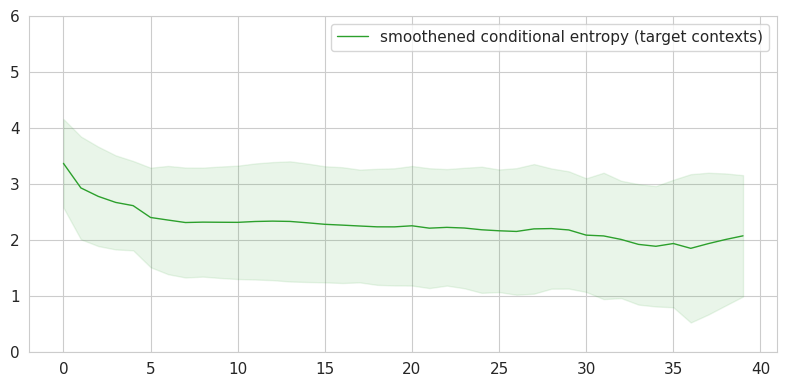

In [12]:
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
# plot_avg_entropies_mean_std(human_entropies, ax, 'human data entropy', color='darkgreen')
plot_avg_entropies_mean_std(human_ma_entropies, 'smoothened conditional entropy (target contexts)', ax=ax, color='tab:green', linewidth=1.0, std_dev=1.5)

## Examples of generation

In [13]:
lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN,
)

Text(0, 0.5, 'Nats')

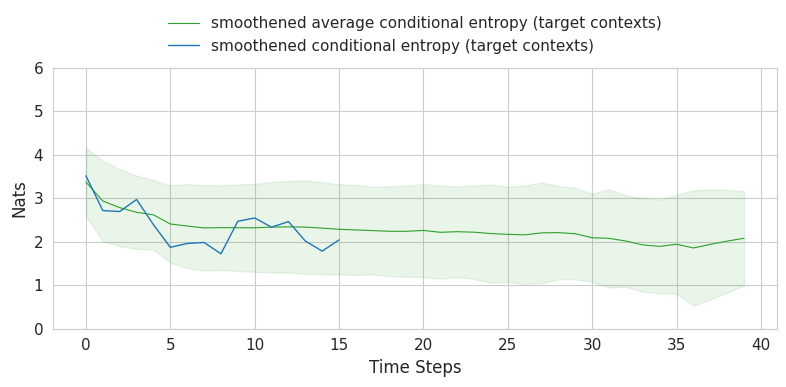

In [14]:
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

plot_avg_entropies_mean_std(human_ma_entropies, 'smoothened average conditional entropy (target contexts)', ax=ax, color='tab:green', std_dev=1.5, linewidth=0.8)
lpdh.plot(x="index", y='entropy_ma',  ax=ax, color='tab:blue', linewidth=1.0, label="smoothened conditional entropy (target contexts)")
# lpdh.plot(x="index", y='entropy', ax=ax, color='tab:blue', linewidth=0.8, label="conditional entropy (target contexts)", linestyle='dashed')
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=1, title=None, frameon=False)
ax.set_xlabel("Time Steps")
ax.set_ylabel("Nats")


# Entropy of Model Data

In [15]:
model_greedy_dataframe = pd.read_json(greedy_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})
model_greedy_dataframe.dropna(inplace=True)

model_greedy_beamblock_dataframe = pd.read_json(greedy_beamblock_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_beam_dataframe = pd.read_json(beam_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})
model_beam_dataframe.dropna(inplace=True)

model_beam_beamblock_dataframe = pd.read_json(beam_beamblock_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_topp_dataframe = pd.read_json(topp_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_ead_dataframe = pd.read_json(ead_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

In [47]:
lreps = []
creps = []
reps = []
for i,datapoint in model_beam_dataframe.iterrows():
    rep, crep, lrep, *_ = compute_ngram_repeats(datapoint.context, datapoint.model_text)
    reps.append(rep)
    lreps.append(lrep)
    creps.append(crep)

model_beam_dataframe['reps'] = reps
model_beam_dataframe['creps'] = creps
model_beam_dataframe['lreps'] = lreps

In [58]:
with_2_repeats = model_beam_dataframe[model_beam_dataframe.lreps > 7]

# for i, datapoint in with_2_repeats.iterrows():
#     print(datapoint.context)
#     print_sample(datapoint.context, datapoint.model_text)
#     print()



In [59]:
with_2_repeats_sample = with_2_repeats.iloc[3]
# human_datapoint_idx = human_dataframe[(with_2_repeats_sample.context == human_datapoint.context)].index.item()
# print(human_datapoint_idx)


In [60]:
human_datapoint_idx = model_beam_dataframe[(with_2_repeats_sample.context == model_beam_dataframe.context)].index.item()


# human_datapoint_idx=1
# human_datapoint = human_dataframe.iloc[human_datapoint_idx]
# human_datapoint_idx = 39

In [61]:
human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]
beamblock_sample = model_beam_beamblock_dataframe.iloc[human_datapoint_idx]
nucleus_sample = model_topp_dataframe.iloc[human_datapoint_idx]
ead_sample = model_ead_dataframe.iloc[human_datapoint_idx]

print("Context:")
print(human_datapoint.context)
print()
print("Target:")
print(human_datapoint.model_text)
print()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text)
print()
print("Beam Model Text: ")
print_sample(human_datapoint.context, beam_sample.model_text)
print()
# print("Temperature sampled Model Text:")
# print_sample(human_datapoint.context, temp_sample.model_text)
# print()
print("Nucleus sampled Model Text:")
print_sample(human_datapoint.context, nucleus_sample.model_text)
print()
print("BeamBlock Model Text:")
print_sample(human_datapoint.context, beamblock_sample.model_text)
print()
print("EAG Model V1 Text:")
print_sample(human_datapoint.context, ead_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

# print("EAG Model V2 Text:")
# print_sample(human_datapoint.context, eag_v2_sample.model_text)
# # print(f"Num. Voilations: {eag_sample.voilations}")
# print()

# print("EAG Model V3 Text:")
# print_sample(human_datapoint.context, eag_v3_sample.model_text)
# # print(f"Num. Voilations: {eag_sample.voilations}")
# print()

# print("EABS Model Text:")
# print_sample(human_datapoint.context, eabs_sample.model_text.replace("\n", "\\n"))
# print(f"Num. Voilations: {eabs_sample.voilations}")
# print()

Context:
well , i've trouble looking people in the eye , that's a job !
why to look into eyes ? ? ?
they can see how you really feel
I look people in the forehead when I sing karaoke. It's less scary


Target:
I sing in the shower sometimes

Greedy Model Text: 
 I'm not sure if I'm good at singing or not. I'm not sure if I'm good enough to do it.

Beam Model Text: 
 That's a good way to practice looking people in the eye. It's a good way to practice looking people in the eye.

Nucleus sampled Model Text:
 I look in the mirror a lot, but when I sing I try to use my best face for people to see me.

BeamBlock Model Text:
 That's a good way to look at it. I'm sure you're a great singer.

EAG Model V1 Text:
 That's probably more comfortable than looking into their eyes.  I think we all do that at some point.



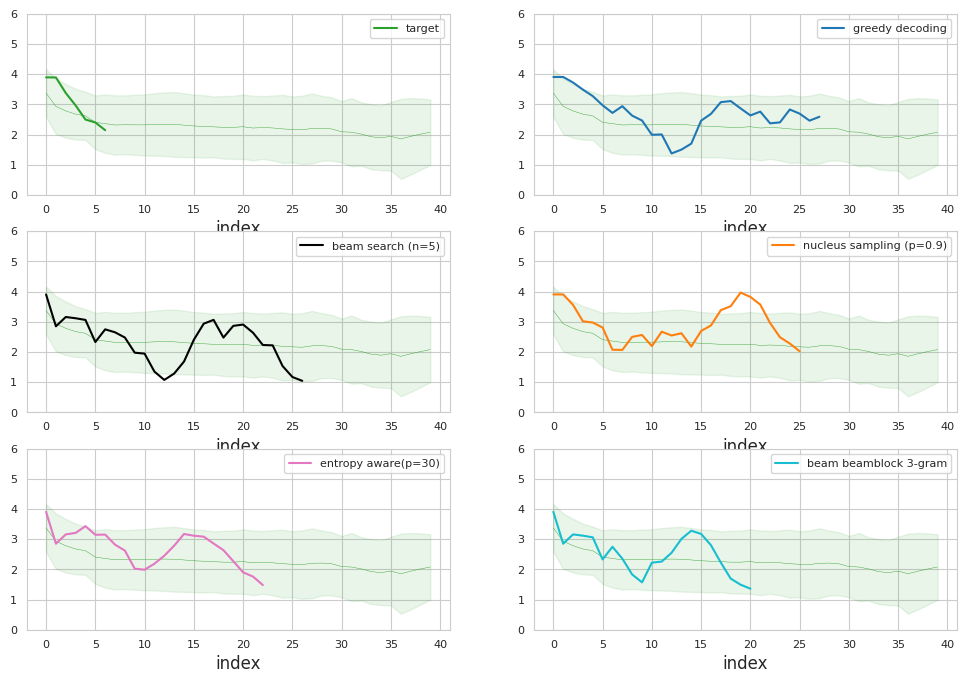

In [63]:
lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,is_seq2seq=True, max_source_len=MAX_SOURCE_LEN,
)

greedy_labeled_datapoint = process_datapoint(
    model=model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN,
)

beam_labeled_datapoint = process_datapoint(
    model=model, datapoint=beam_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN,
)

beamblock_labeled_datapoint = process_datapoint(
    model=model, datapoint=beamblock_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN,
)

nucleus_labeled_datapoint = process_datapoint(
    model=model, datapoint=nucleus_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN,
)

ead_labeled_datapoint = process_datapoint(
    model=model, datapoint=ead_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN,
)

# topk_labeled_datapoint = process_datapoint(
#     model=model, datapoint=topk_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN,
# )

# typical_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=typical_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )



# eag_v2_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=eag_v2_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eag_v3_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=eag_v3_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eabs_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eabs_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

fig, axs = plt.subplots(3,2, figsize=(12, 8))
plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[0, 0], color='tab:green', std_dev=1.5, linewidth=0.3)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0,0], label='target', color='tab:green')
axs[0,0].legend(fontsize=8, loc="upper right")
axs[0,0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies, ax=axs[0, 1], color='tab:green', std_dev=1.5, linewidth=0.3)
greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 1], label='greedy decoding', color='tab:blue')
axs[0, 1].legend(fontsize=8, loc="upper right")
axs[0, 1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1, 0], color='tab:green', std_dev=1.5, linewidth=0.3)
beam_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1, 0], label='beam search (n=5)', color='black')
axs[1, 0].legend(fontsize=8, loc="upper right")
axs[1, 0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1, 1], color='tab:green', std_dev=1.5, linewidth=0.3)
nucleus_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1, 1], label='nucleus sampling (p=0.9)', color='tab:orange')
axs[1, 1].legend(fontsize=8, loc="upper right")
axs[1, 1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[2,0], color='tab:green', std_dev=1.5, linewidth=0.3)
ead_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2,0], label='entropy aware(p=30)', color='tab:pink')
axs[2,0].legend(fontsize=8, loc="upper right")
axs[2,0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[2,1], color='tab:green', std_dev=1.5, linewidth=0.3)
beamblock_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2,1], label='beam beamblock 3-gram', color='tab:cyan')
axs[2,1].legend(fontsize=8, loc="upper right")
axs[2,1].tick_params(labelsize=8)

# plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[3,0],  color='tab:green', std_dev=1.0, linewidth=0.3)
# temp_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[3, 0], label='temp. sampling (temp=0.8)', color='tab:red')
# axs[3, 0].legend(fontsize=8, loc="upper right")
# axs[3, 0].tick_params(labelsize=8)

# plot_avg_entropies_mean_std(human_ma_entropies, ax=axs[3,1], color='tab:green', std_dev=1.0, linewidth=0.3)
# eag_v1_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[3, 1], label='Entropy Aware Decoding', color='tab:olive')
# axs[3, 1].legend(fontsize=8, loc="upper right")
# axs[3, 1].tick_params(labelsize=8)

## Generate using Entropy Aware Greedy Search

In [ ]:
%%script false --no-raise-error

tokenizer.pad_token = tokenizer.eos_token

tokenized_context = tokenizer(human_datapoint.context, return_tensors="pt")
tokenized_context = tokenized_context.to('cuda')

gpt2_model.greedy_search(**tokenized_context, max_length=1024, pad_token_id=tokenizer.eos_token_id)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
%%script false --no-raise-error
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
test_dataloader = DataLoader(tokenized_writing_prompt_testset, collate_fn=data_collator, batch_size=1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Compute Average entropy across timesteps.

### For all model generated data

In [19]:
# Greedy
# model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, model, tokenizer, column_prefix='model_generated_greedy', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True, is_seq2seq=True,  max_source_len=MAX_SOURCE_LEN)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/a1239922023df50fa8471df3b3a033e9-c565657fbe27b7aaf47dcc290dd54faf-model_generated_greedy-40-1000-entropy_ma-5-100-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/a1239922023df50fa8471df3b3a033e9-c565657fbe27b7aaf47dcc290dd54faf-model_generated_greedy-40-1000-entropy_ma-5-100-avgs.csv


In [35]:
model_gen_greedy_beamblock_avg_ma_entropy_pd, model_gen_greedy_beamblock_ma_entropies = compute_average_across_sequences(model_greedy_beamblock_dataframe, model, tokenizer, column_prefix='model_generated_greedy_beamblock', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True, is_seq2seq=True,  max_source_len=MAX_SOURCE_LEN)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/6629333fc44cc0e16d71dfe3547ca9f6-c565657fbe27b7aaf47dcc290dd54faf-model_generated_greedy_beamblock-40-1000-entropy_ma-5-100-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/6629333fc44cc0e16d71dfe3547ca9f6-c565657fbe27b7aaf47dcc290dd54faf-model_generated_greedy_beamblock-40-1000-entropy_ma-5-100-avgs.csv


In [21]:
# Beam
# model_gen_beam_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_beam_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_beam',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_beam_avg_ma_entropy_pd, model_gen_beam_ma_entropies = compute_average_across_sequences(model_beam_dataframe, model, tokenizer, column_prefix='model_generated_beam', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True, is_seq2seq=True,  max_source_len=MAX_SOURCE_LEN)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/5b7a3c109562385625549cf32a77dbe2-c565657fbe27b7aaf47dcc290dd54faf-model_generated_beam-40-1000-entropy_ma-5-100-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/5b7a3c109562385625549cf32a77dbe2-c565657fbe27b7aaf47dcc290dd54faf-model_generated_beam-40-1000-entropy_ma-5-100-avgs.csv


In [22]:
model_gen_beam_beamblock_avg_ma_entropy_pd, model_gen_beam_beamblock_ma_entropies = compute_average_across_sequences(model_beam_beamblock_dataframe, model, tokenizer, column_prefix='model_generated_beam_beamblock', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True, is_seq2seq=True,  max_source_len=MAX_SOURCE_LEN)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/06c619514c4d8300d3313fb9a9e97ace-c565657fbe27b7aaf47dcc290dd54faf-model_generated_beam_beamblock-40-1000-entropy_ma-5-100-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/06c619514c4d8300d3313fb9a9e97ace-c565657fbe27b7aaf47dcc290dd54faf-model_generated_beam_beamblock-40-1000-entropy_ma-5-100-avgs.csv


In [23]:
# Nucleus
# model_gen_nucleus_avg_entropy_pd, model_gen_nucleus_entropies = compute_average_across_sequences(model_nucleus_dataframe, model, tokenizer, column_prefix='model_generated_nucleus',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_nucleus_avg_ma_entropy_pd, model_gen_nucleus_ma_entropies = compute_average_across_sequences(model_topp_dataframe, model, tokenizer, column_prefix='model_generated_nucleus', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True, is_seq2seq=True,  max_source_len=MAX_SOURCE_LEN)


Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/c8d601bfcf4498b713ca2739e15723e4-c565657fbe27b7aaf47dcc290dd54faf-model_generated_nucleus-40-1000-entropy_ma-5-100-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/c8d601bfcf4498b713ca2739e15723e4-c565657fbe27b7aaf47dcc290dd54faf-model_generated_nucleus-40-1000-entropy_ma-5-100-avgs.csv


In [24]:
# Topk
# model_gen_topk_avg_entropy_pd, model_gen_topk_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

# model_gen_topk_avg_ma_entropy_pd, model_gen_topk_ma_entropies = compute_average_across_sequences(model_topk_dataframe, model, tokenizer, column_prefix='model_generated_topk', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True, is_seq2seq=True,  max_source_len=MAX_SOURCE_LEN)


In [38]:
# Typical Decoding
# model_gen_typical_avg_entropy_pd, model_gen_typical_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_ead_avg_ma_entropy_pd, model_gen_ead_ma_entropies = compute_average_across_sequences(model_ead_dataframe, model, tokenizer, column_prefix='model_generated_entropy_aware_decoding', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True, is_seq2seq=True,  max_source_len=MAX_SOURCE_LEN)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/5f551a0709769ab63e42992d3d3d555f-c565657fbe27b7aaf47dcc290dd54faf-model_generated_entropy_aware_decoding-40-1000-entropy_ma-5-100-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/5f551a0709769ab63e42992d3d3d555f-c565657fbe27b7aaf47dcc290dd54faf-model_generated_entropy_aware_decoding-40-1000-entropy_ma-5-100-avgs.csv


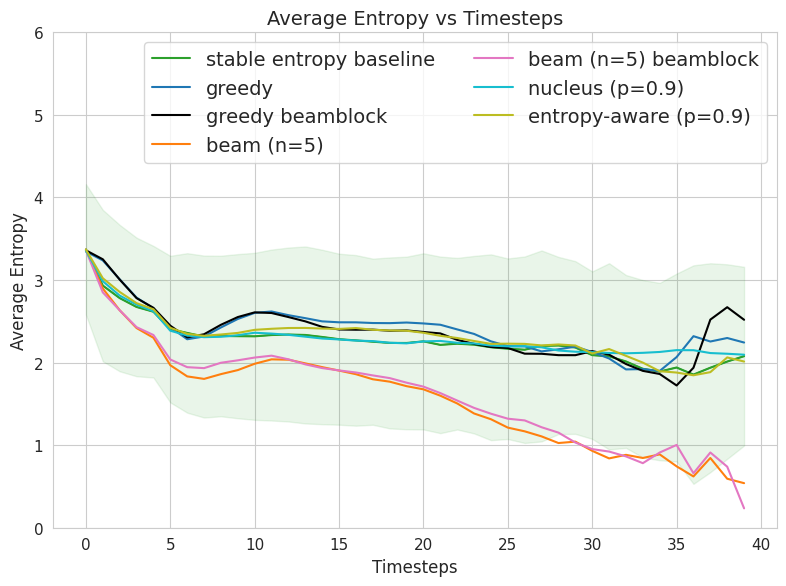

In [42]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, 
                                            model_gen_greedy_avg_ma_entropy_pd,  model_gen_greedy_beamblock_avg_ma_entropy_pd,
                                            model_gen_beam_avg_ma_entropy_pd, 
                                            model_gen_beam_beamblock_avg_ma_entropy_pd,
                                            model_gen_nucleus_avg_ma_entropy_pd, 
                                            model_gen_ead_avg_ma_entropy_pd],axis=1)

# model_vs_human_avg_entropies = model_vs_human_avg_entropies.drop(["Unnamed: 0"], axis=1)

model_vs_human_avg_entropies = model_vs_human_avg_entropies.rename(columns={
                                                   'human_generated_entropy_ma': 'stable entropy baseline',
                                                   'model_generated_greedy_entropy_ma':'greedy', 
                                                   'model_generated_greedy_beamblock_entropy_ma': 'greedy beamblock',
                                                   'model_generated_beam_entropy_ma': 'beam (n=5)',
                                                   'model_generated_beam_beamblock_entropy_ma': 'beam (n=5) beamblock',
                                                   'model_generated_nucleus_entropy_ma': 'nucleus (p=0.9)',
                                                   'model_generated_topk_entropy_ma': 'top-k (k=30)',
                                                #    'model_generated_typical_decoding_entropy_ma': 'typical (tau = 0.9)',
                                                   'model_generated_entropy_aware_decoding_entropy_ma': 'entropy-aware (p=0.9)'})
figsize=(8,6)
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

# plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=1)
plot_avg_entropies_mean_std(human_ma_entropies,  ax=ax, color='tab:green', std_dev=1.5, linewidth=1.0)

styles=['tab:green', 'tab:blue', 'black', 'tab:orange', 'tab:pink', 'tab:cyan', 'tab:olive']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps', 
    figsize=figsize,
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)
plt.legend(fontsize=14, ncol=2)

AttributeError: 'str' object has no attribute 'yaxis'

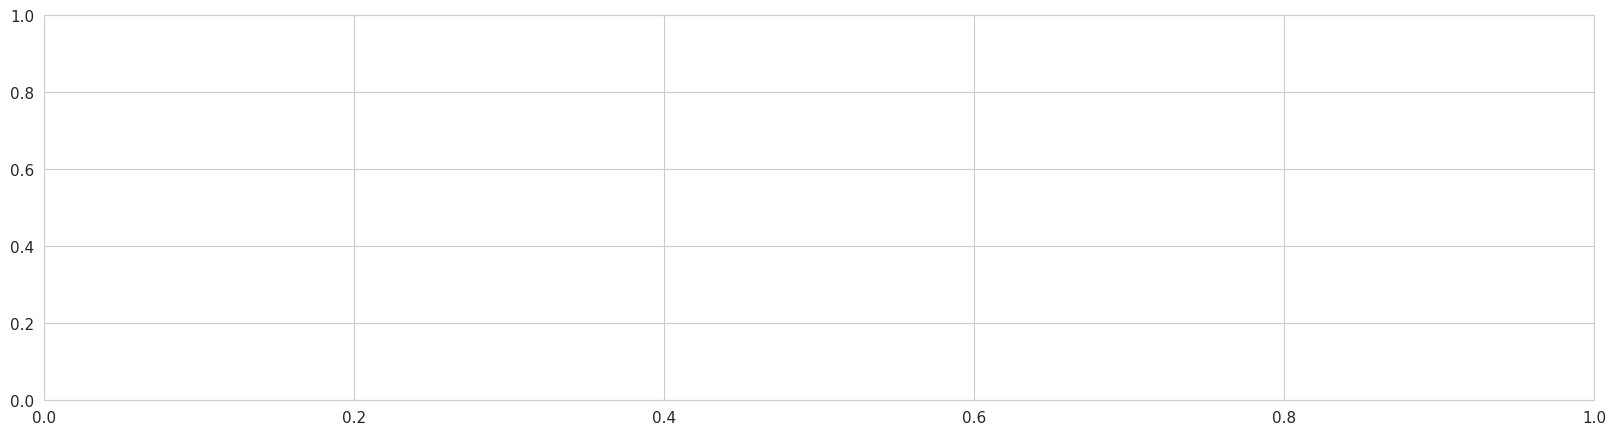

In [27]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd,  model_gen_beam_avg_ma_entropy_pd, model_gen_nucleus_avg_ma_entropy_pd, model_gen_ead_avg_ma_entropy_pd],axis=1)

figsize = (20, 5)
fig, ax = plt.subplots(figsize=figsize)

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

styles=['tab:green', 'tab:blue', 'black', 'tab:orange', 'tab:pink', 'tab:cyan']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps', 
    figsize=figsize,
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)

# Analysis to discover entropy awareness criteria

In [78]:

human_datapoint = human_dataframe.sample().iloc[0]
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]



Greedy Model Text: 
The first time I saw her, I was so excited. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able 

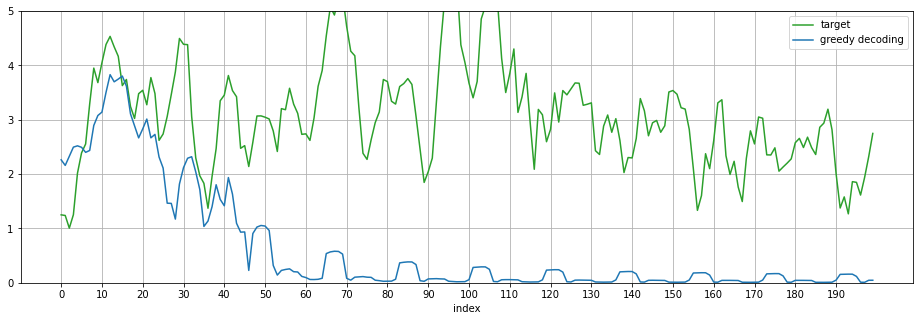

In [79]:
fig, ax = plt.subplots(figsize=(16,5))

lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)
lpdh['dent_cumsum'] = lpdh['dent'].cumsum()

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=greedy_sample, width=5, max_len=MAX_LEN, 
)
greedy_labeled_datapoint['dent_cumsum'] = greedy_labeled_datapoint['dent'].cumsum()

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=beam_sample, width=5, max_len=MAX_LEN,
)
beam_labeled_datapoint['dent'] = beam_labeled_datapoint['dent'].cumsum()

# plot_avg_entropies_mean_std(human_ma_entropies[:], ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
lpdh[:200].plot(x="index", y='entropy_ma', ylim=(-0,5), ax=ax, label='target', color='tab:green')


greedy_labeled_datapoint[:200].plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:blue')
# greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:orange')

ax.set_xticks(np.arange(len(greedy_labeled_datapoint[:200]['index']), step=10))
plt.grid()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "<n>"))
print()

In [80]:
greedy_labeled_datapoint['token'][20:50]

20         Ġto
21         Ġbe
22       Ġable
23         Ġto
24       Ġhold
25        Ġher
26         Ġin
27         Ġmy
28       Ġarms
29           .
30          ĠI
31        Ġwas
32         Ġso
33    Ġexcited
34         Ġto
35        Ġsee
36        Ġher
37           ,
38         Ġto
39         Ġbe
40       Ġable
41         Ġto
42       Ġhold
43        Ġher
44         Ġin
45         Ġmy
46       Ġarms
47           .
48          ĠI
49        Ġwas
Name: token, dtype: object

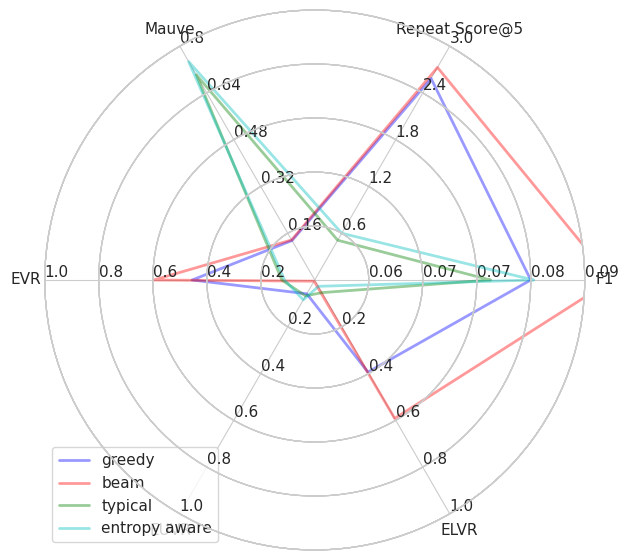

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics

def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))
        
        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


if __name__ == "__main__":
    # example data
    variables = ("F1", "Repeat Score@5", "Mauve", 
                "EVR", "EUVR", "ELVR")
    ranges = [(0.05, 0.09), (0, 3), (0, 0.8),
            (0, 1), (0, 1), (0, 1)]
    greedy = (0.082, 2.585, 0.135, 0.454, 0.059, 0.394)
    beam = (0.094, 2.727, 0.137, 0.596, 0.005, 0.592)
    typical = (0.076, 0.51, 0.702, 0.122, 0.068, 0.054)
    entropy_aware = (0.0824,0.6, 0.747, 0.112, 0.085, 0.027)
    # plotting
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, ranges)
    radar.plot(greedy,  lw=2, color="b", alpha=0.4, label="greedy")
    # radar.fill(greedy, alpha=0.2)

    radar.plot(beam,  lw=2, color="r", alpha=0.4, label="beam")
    # radar.fill(beam, alpha=0.2)

    radar.plot(typical,  lw=2, color="g", alpha=0.4, label="typical")
    # radar.fill(typical, alpha=0.2)

    radar.plot(entropy_aware,  lw=2, color="c", alpha=0.4, label="entropy aware")
    # radar.fill(entropy_aware, alpha=0.2)
    radar.ax.legend()